## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from gensim.corpora.dictionary import Dictionary 
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('./complaints.json',"r")
  

# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [4]:
# checking the shape of dataframe
df.shape

(78313, 22)

In [5]:
# checking the head of dataframe
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
#print the column names
for index,column in enumerate(df.columns):
    print(index + 1 ,')', column)

1 ) _index
2 ) _type
3 ) _id
4 ) _score
5 ) _source.tags
6 ) _source.zip_code
7 ) _source.complaint_id
8 ) _source.issue
9 ) _source.date_received
10 ) _source.state
11 ) _source.consumer_disputed
12 ) _source.product
13 ) _source.company_response
14 ) _source.company
15 ) _source.submitted_via
16 ) _source.date_sent_to_company
17 ) _source.company_public_response
18 ) _source.sub_product
19 ) _source.timely
20 ) _source.complaint_what_happened
21 ) _source.sub_issue
22 ) _source.consumer_consent_provided


In [7]:
# removing _source from column names
for column in df.columns:
    if '_source.' in column:
        new_column_name = column.replace('_source.','').strip()
        columns_dict = {}
        columns_dict[column]  = new_column_name
        df.rename(columns=columns_dict,inplace=True)

for index,column in enumerate(df.columns):
    print(index + 1 ,')', column)

1 ) _index
2 ) _type
3 ) _id
4 ) _score
5 ) tags
6 ) zip_code
7 ) complaint_id
8 ) issue
9 ) date_received
10 ) state
11 ) consumer_disputed
12 ) product
13 ) company_response
14 ) company
15 ) submitted_via
16 ) date_sent_to_company
17 ) company_public_response
18 ) sub_product
19 ) timely
20 ) complaint_what_happened
21 ) sub_issue
22 ) consumer_consent_provided


In [8]:
#Assign new column names
new_column_names = {'complaint_what_happened':"complaints"}
df.rename(columns=new_column_names,inplace=True)


In [9]:
# checking percentage of null values in columns 
(df.isnull().sum() | df.eq("").sum()) / df.isnull().count() * 100

_index                        0.000000
_type                         0.000000
_id                           0.000000
_score                        0.000000
tags                         86.081493
zip_code                      8.628197
complaint_id                  0.000000
issue                         0.000000
date_received                 0.000000
state                         2.542362
consumer_disputed             0.000000
product                       0.000000
company_response              0.000000
company                       0.000000
submitted_via                 0.000000
date_sent_to_company          0.000000
company_public_response      99.994892
sub_product                  13.498397
timely                        0.000000
complaints                   73.092590
sub_issue                    59.117899
consumer_consent_provided     1.287143
dtype: float64

In [10]:
#Assign nan in place of blanks in the complaints column
df['complaints'].replace("",np.nan,inplace=True)
df['complaints'].isnull().sum()

57241

In [11]:
df.shape

(78313, 22)

In [12]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaints'],inplace=True)
df['complaints'].isnull().sum()

0

In [13]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [14]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_data(text):
    text = text.lower()
    
    text = re.sub(r'\[.*?\]','',text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation) ,'',text)
    text = re.sub(r'\w*\d\w*','',text)
    # removing masked user info 
    text = re.sub(r'\s*\bx+\b\s*',' ',text)
    return text
    

In [15]:
# applying the cleaning function on the dataset
df_clean = pd.DataFrame(df['complaints'].apply(clean_data))

In [16]:
# loading spacy model
spacy_nlp_model = spacy.load('en_core_web_sm',exclude=['ner'])

In [17]:
#Write your function to Lemmatize the texts
lemma = []
nouns = []

for doc in spacy_nlp_model.pipe(df_clean['complaints'].values, n_process=-1):
    if doc.has_annotation('DEP'):
        lemma_sentence = [token.lemma_ for token in doc]
        nouns_sentence = [token.text for token in doc if token.tag_[:2] == 'NN']
        lemma.append(" ".join(lemma_sentence)) 
        nouns.append(" ".join(nouns_sentence))
    else:
        lemma.append(None)
        nouns.append(None)

In [18]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean['complaints_lemma'] = lemma
df_clean['complaints_pos_removed'] = nouns

In [19]:
df_clean.head()

,complaints,complaints_lemma,complaints_pos_removed
1,good morning my name is and i appreciate it i...,good morning my name be and I appreciate it ...,morning name stop bank cardmember services deb...
2,i upgraded my card in and was told by the ag...,I upgrade my card in and be tell by the ag...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card application identity consent servic...
11,on while trying to book a ticket i came acro...,on while try to book a ticket I come acros...,ticket offer ticket rewards card information o...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son check chase account fund chase bank accoun...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




<AxesSubplot: ylabel='Count'>

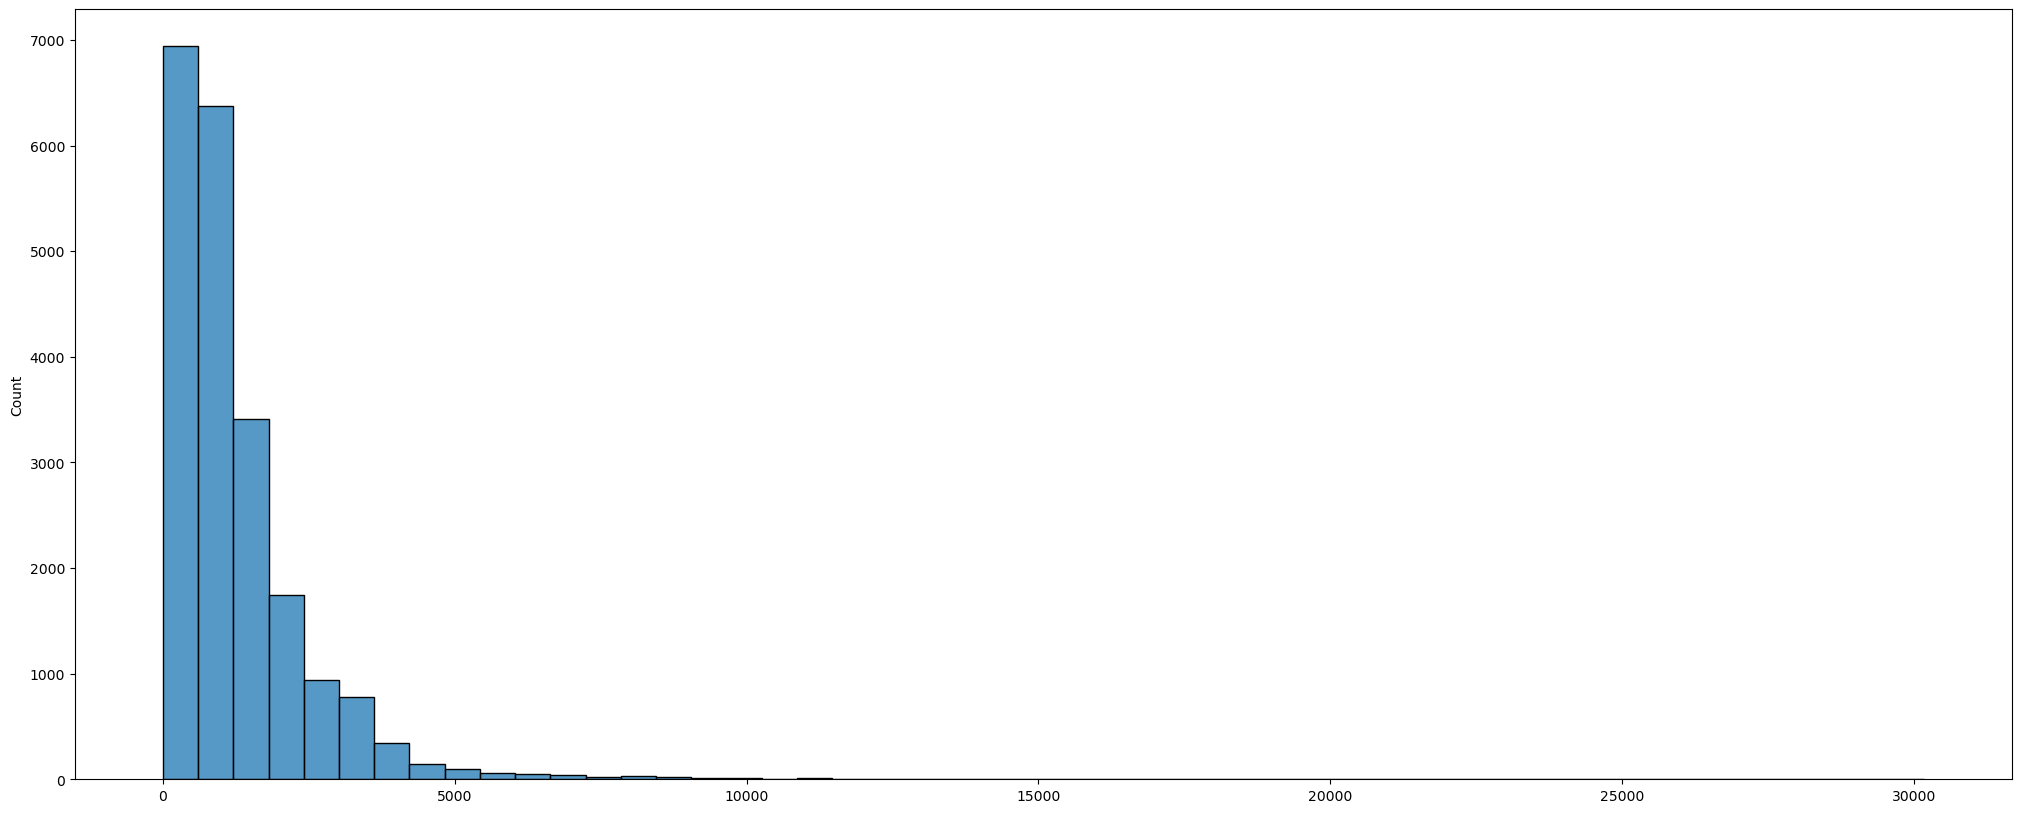

In [22]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaint_len = [len(sen) for sen in df_clean['complaints']]

plt.figure(figsize=[25,10])
sns.histplot(complaint_len,bins=50)

#### Find the top 40 words by frequency among all the articles after processing the text.

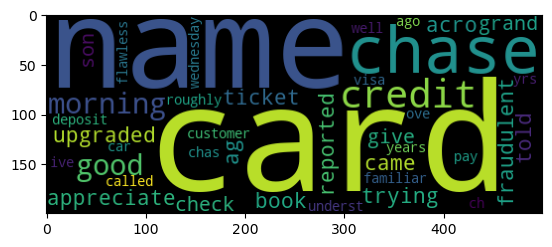

In [124]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_words=40,background_color='black',stopwords=stopwords,width=500,height=200).generate(str(df_clean['complaints']))
plt.imshow(wordcloud)
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [26]:
# function to show ngrams plot
def show_ngram(ngram,ntop):
    try:
        ngram_list = df_clean['complaints_pos_removed'].apply(lambda sentence: list(nltk.ngrams(sentence.split(),ngram)))
        if ngram == 1:
            unigrams = [item[0] for sublist in ngram_list for item in sublist]
        elif ngram == 2:
            bigrams = [item[0] + ' ' + item[1] for sublist in ngram_list for item in sublist]
        else:
            trigrams = [item[0] + ' ' + item[1] + ' ' + item[2] for sublist in ngram_list for item in sublist]
        ngrams_freq = nltk.FreqDist(unigrams if ngram == 1 else bigrams if ngram == 2 else trigrams)

        Word = []
        Frequency = []
        for word, freq in ngrams_freq.most_common(ntop):
            Word.append(word)
            Frequency.append(freq)

        plt.figure(figsize=(25,10))
        sns.barplot(x=Frequency,y=Word)
        plt.show()
    except: 
        return
        

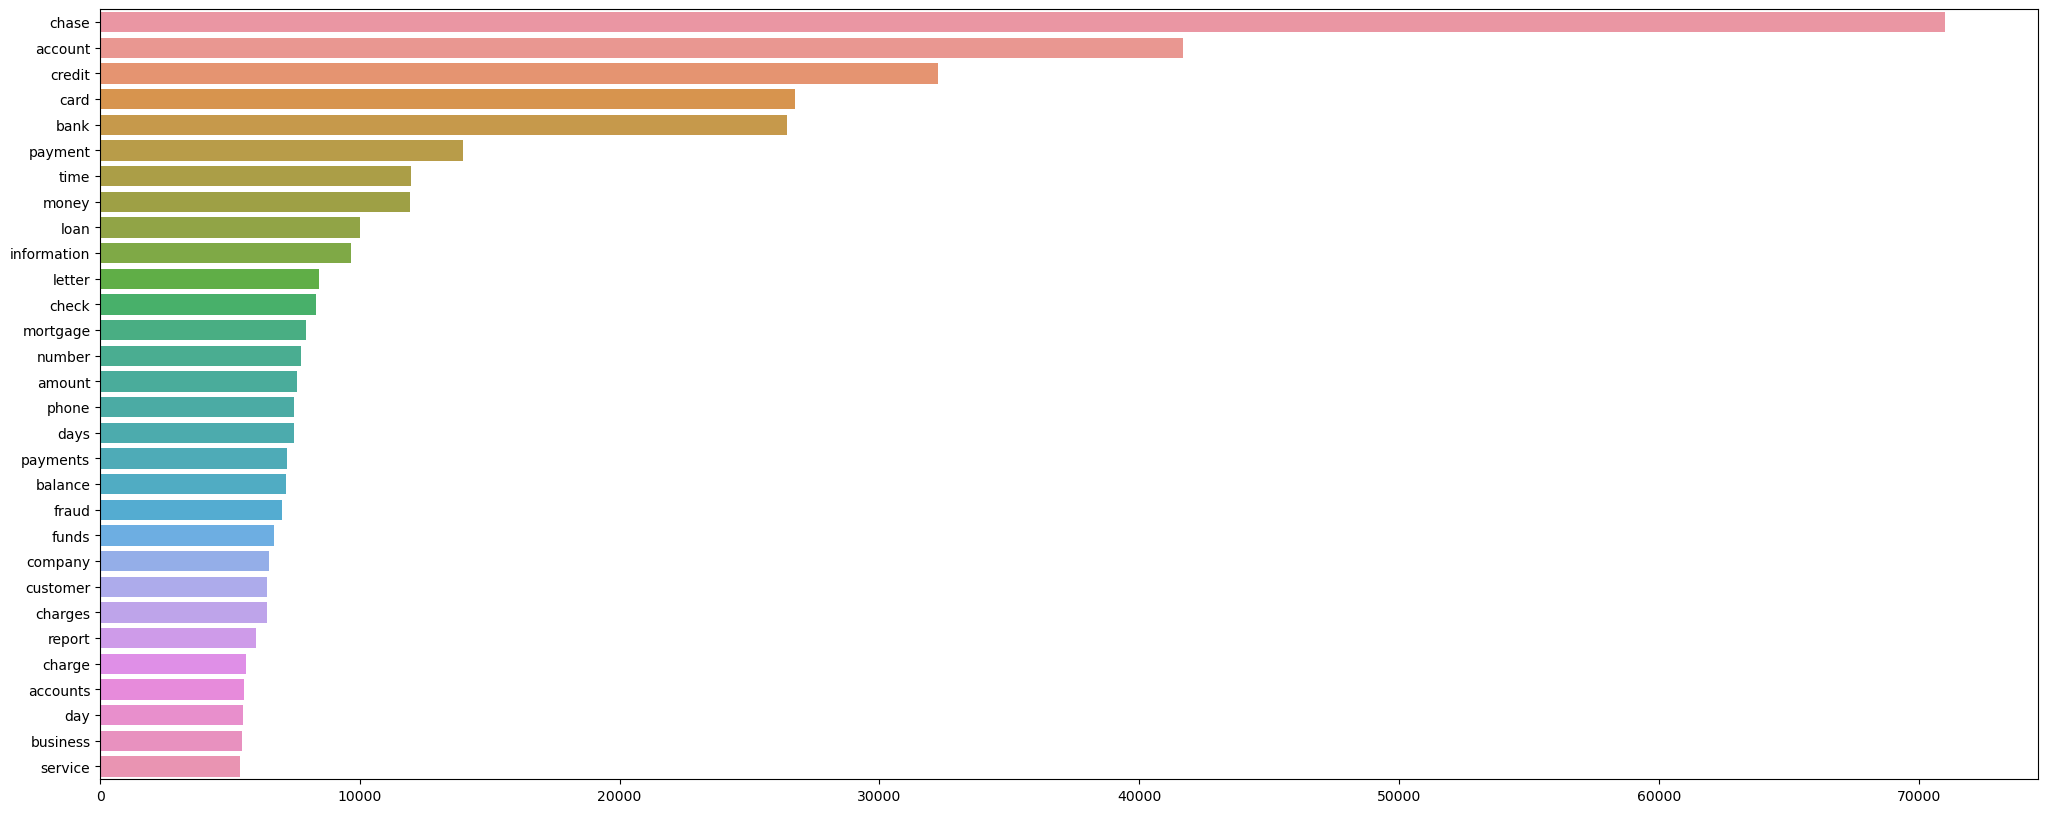

In [27]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
show_ngram(1,30)

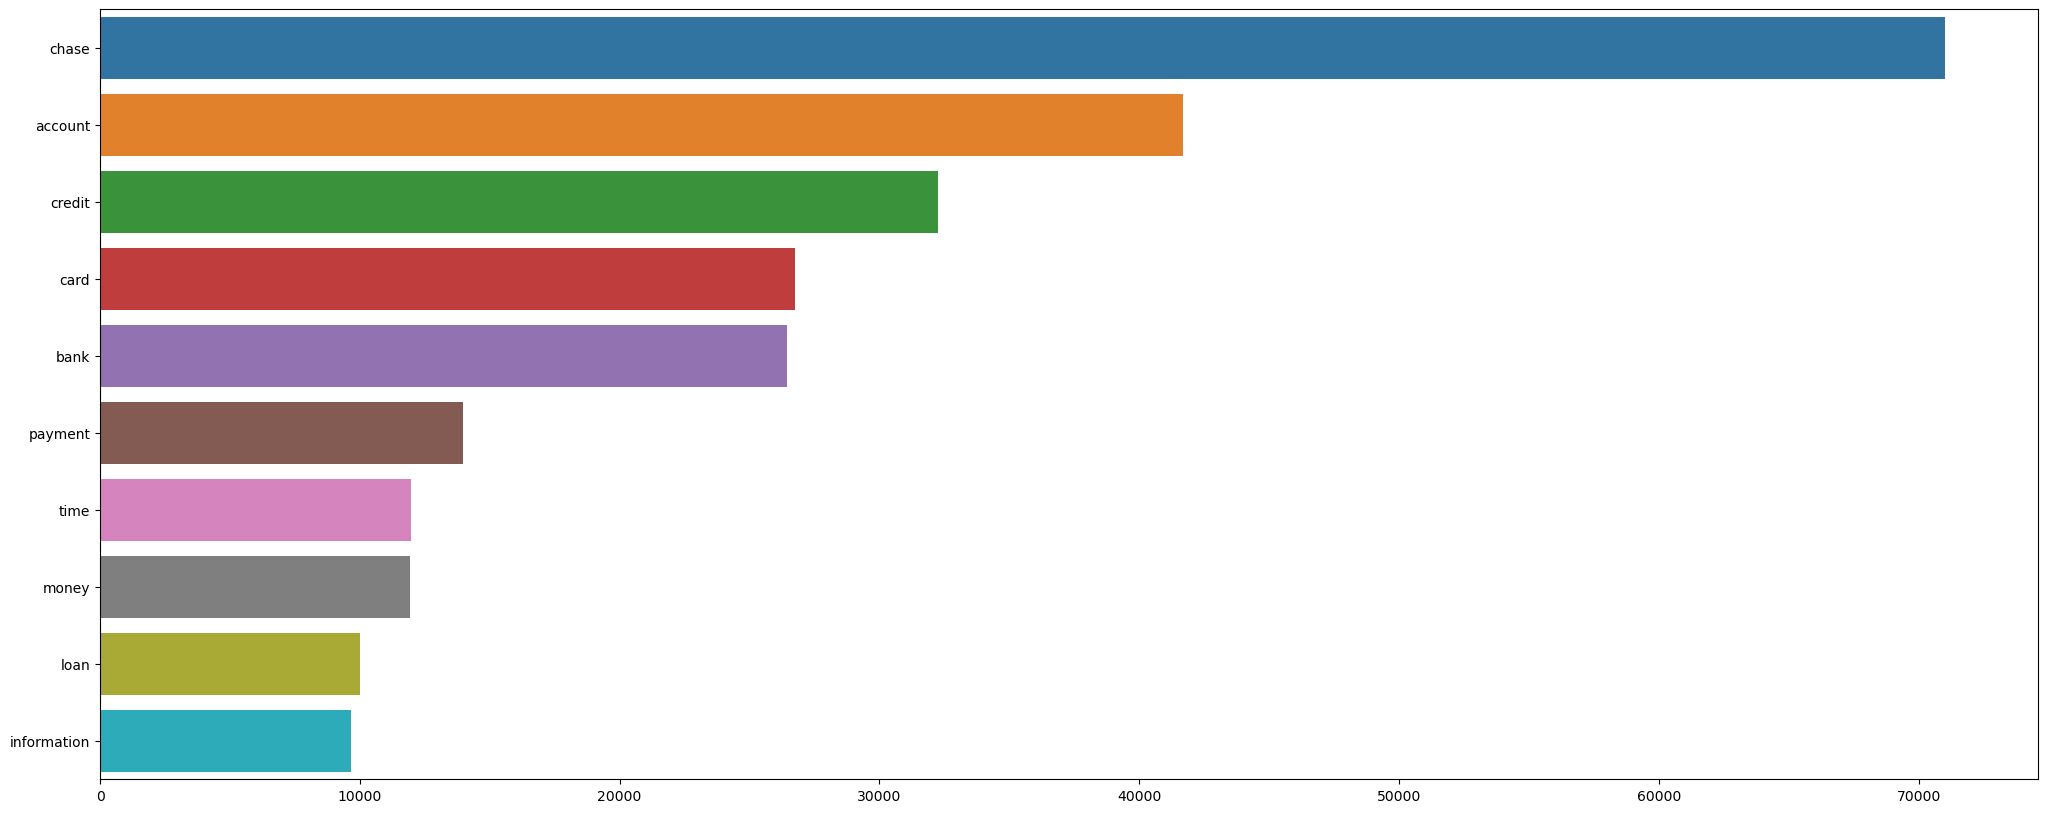

In [28]:
#Print the top 10 words in the unigram frequency
show_ngram(1,10)

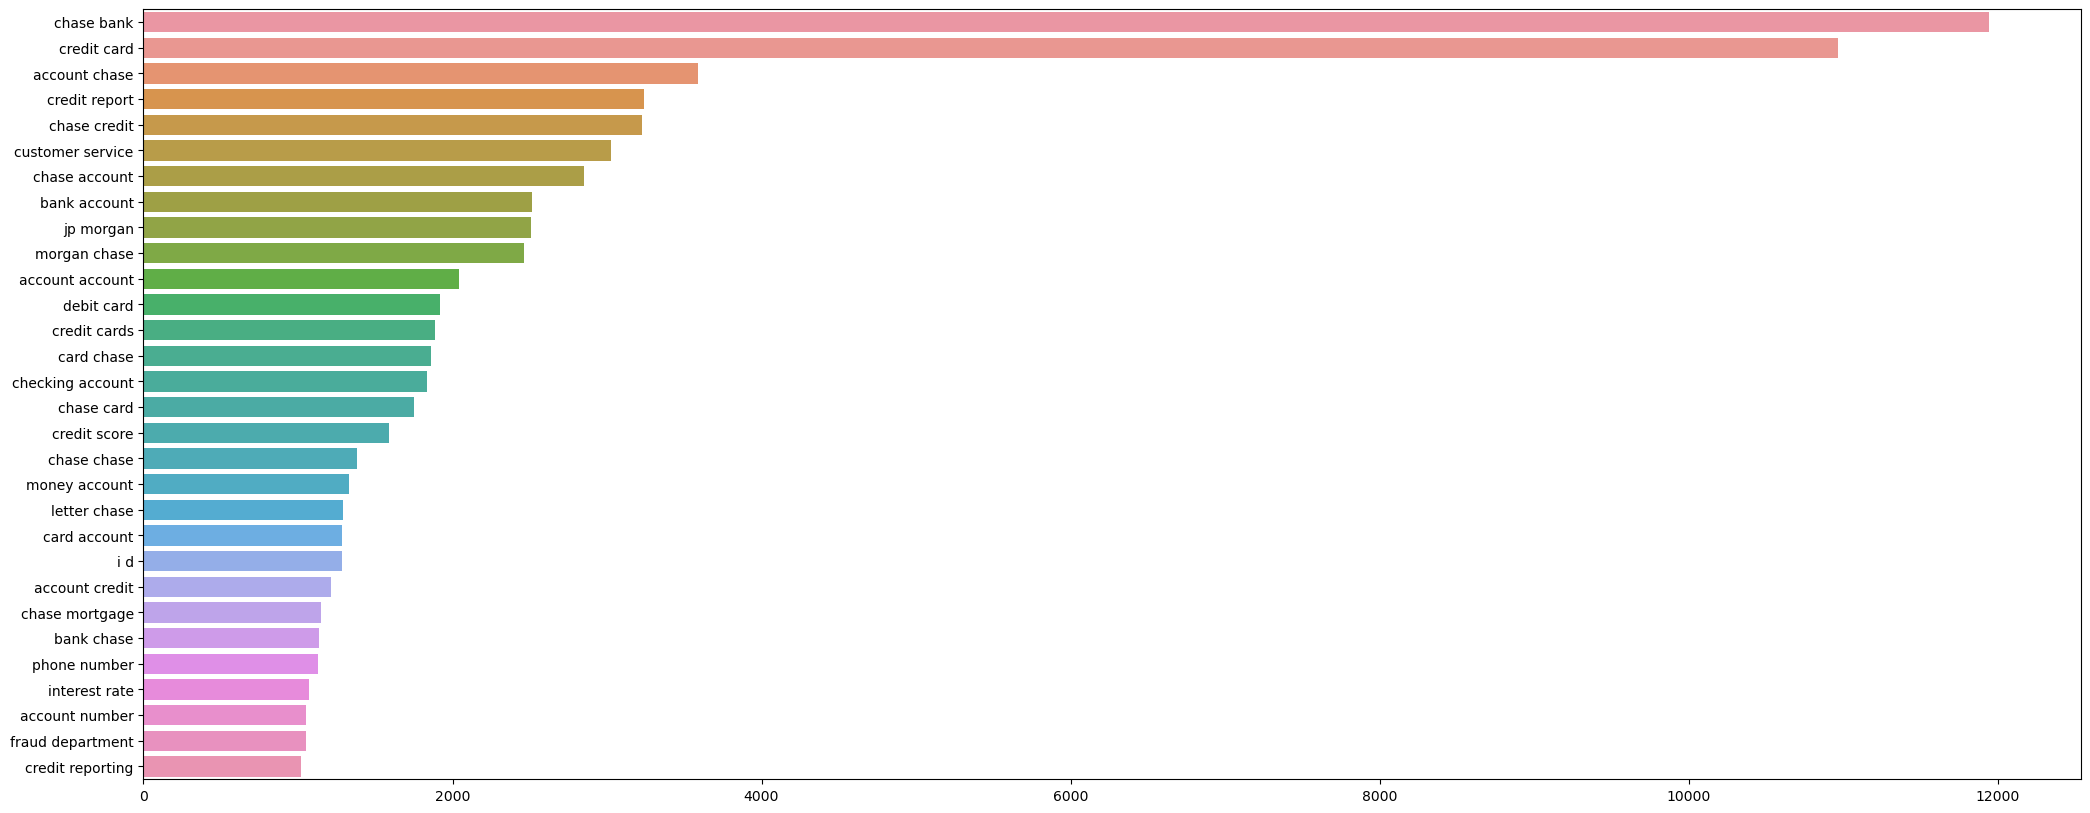

In [29]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
show_ngram(2,30)

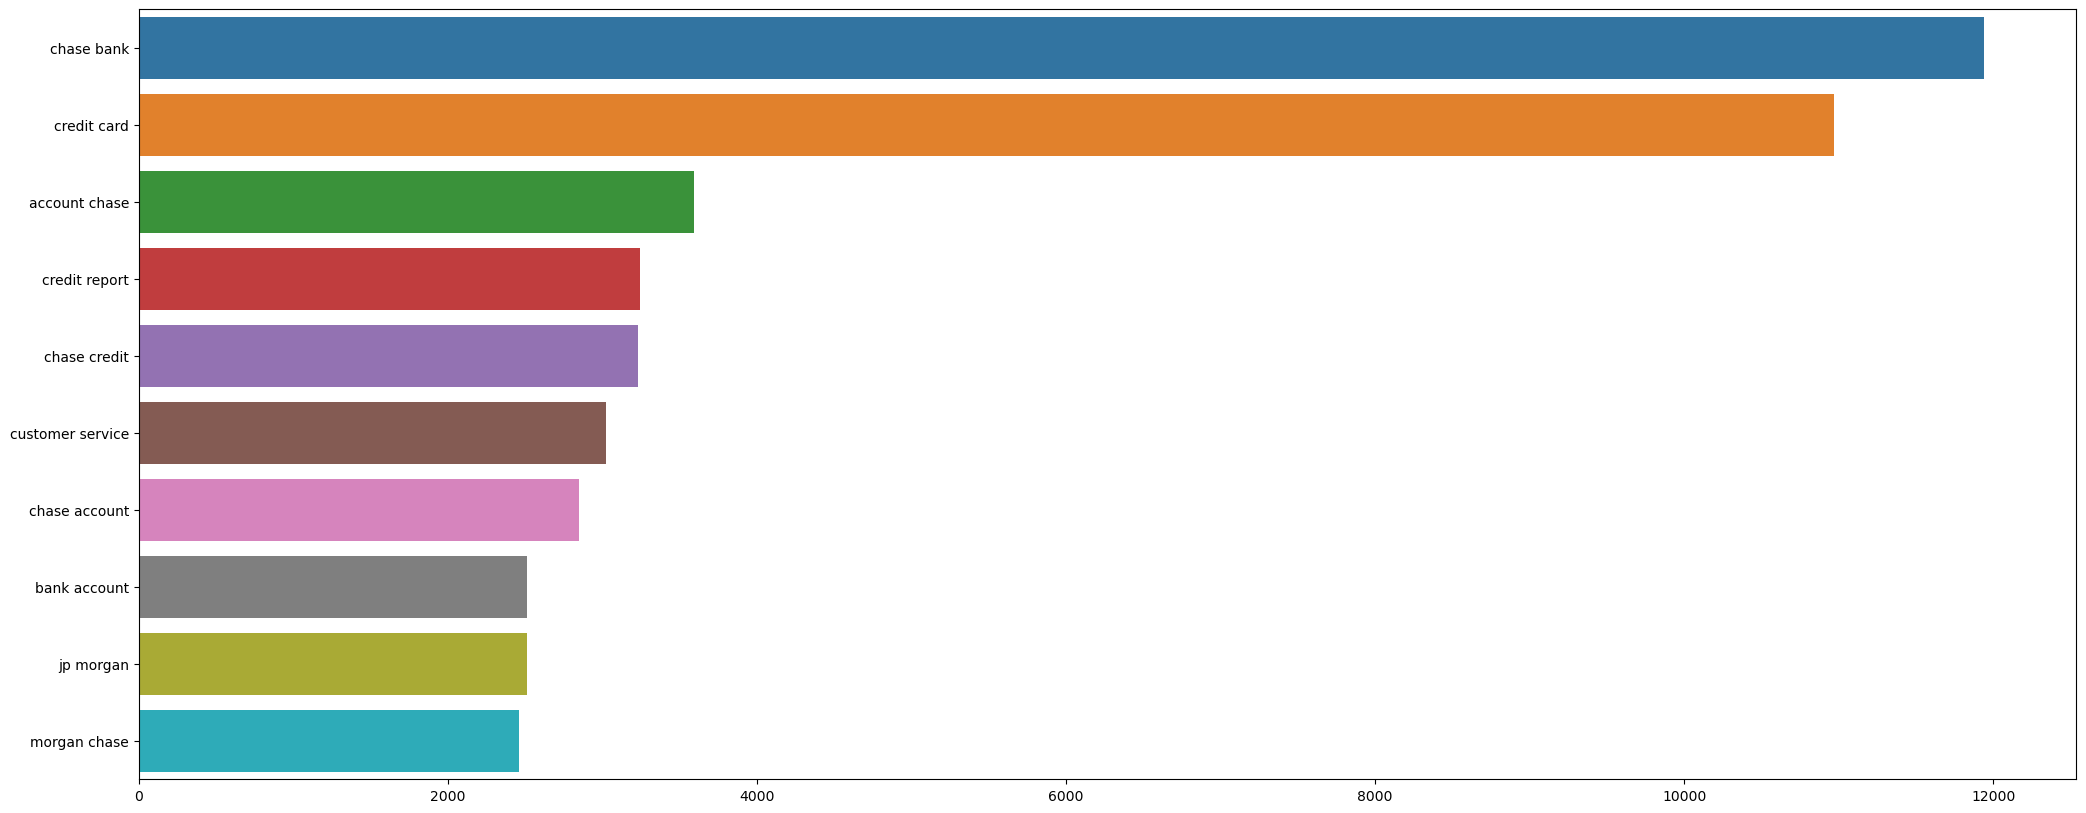

In [30]:
#Print the top 10 words in the bigram frequency
show_ngram(2,10)

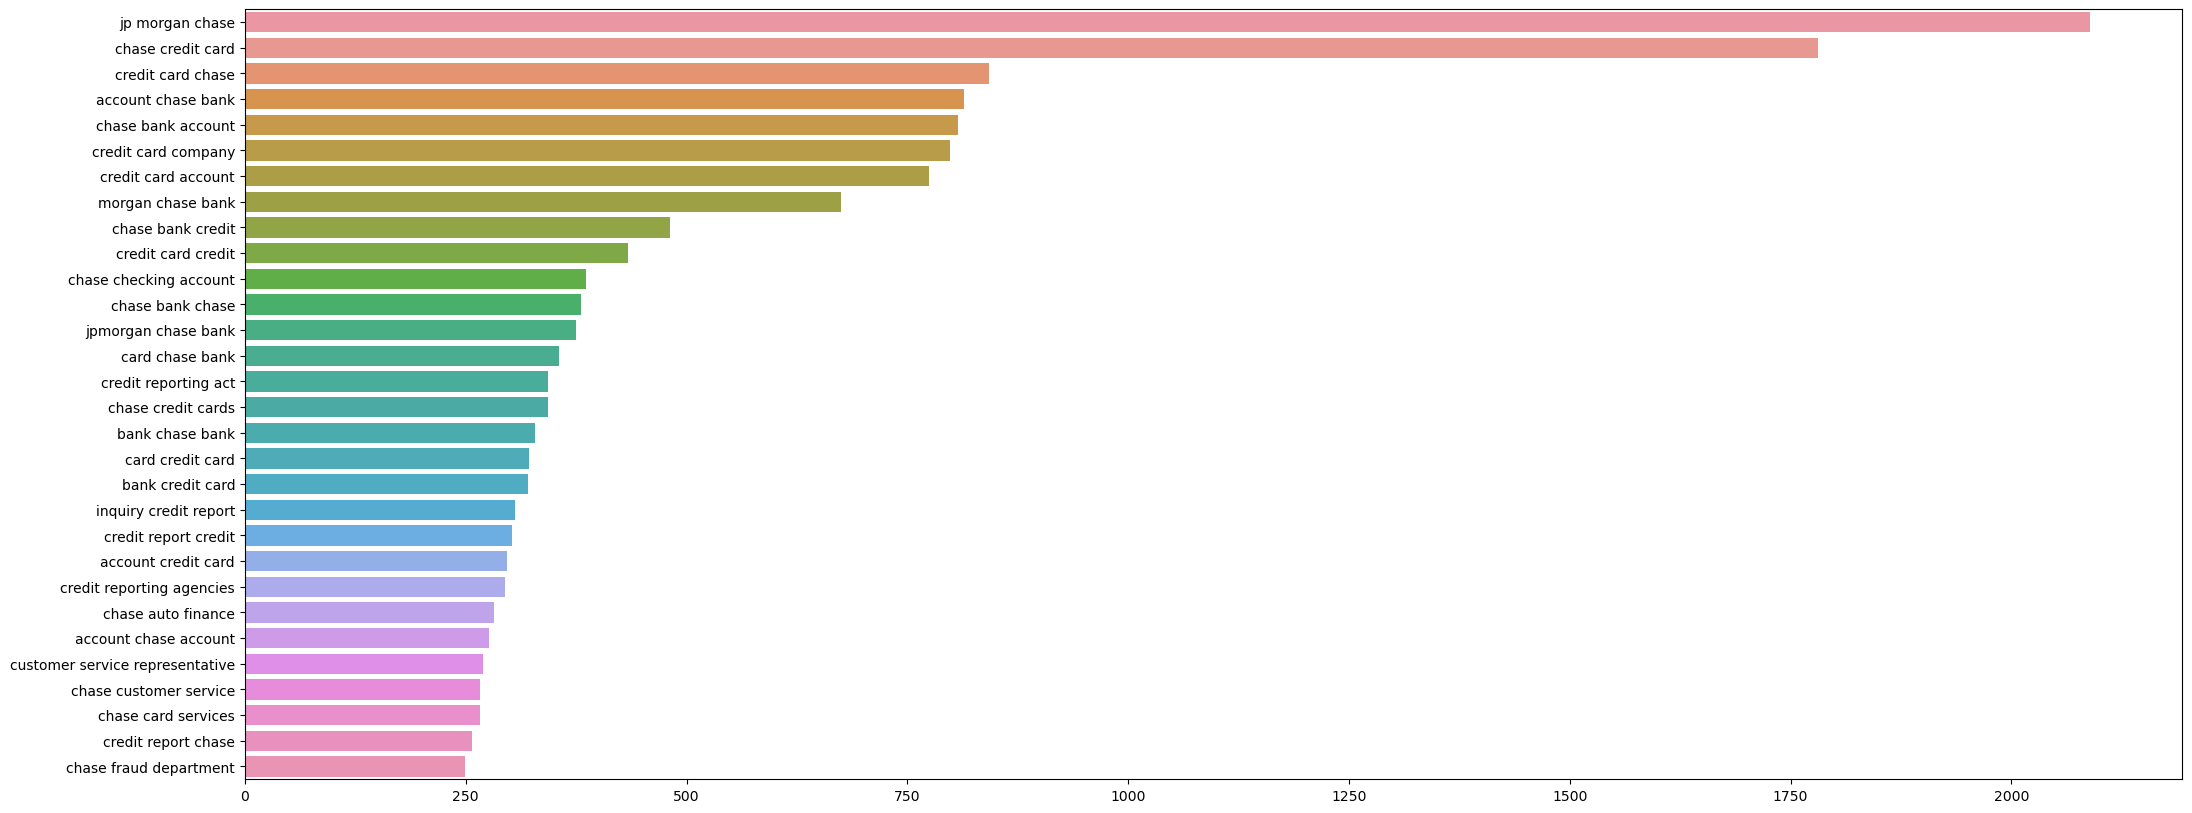

In [31]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
show_ngram(3,30)


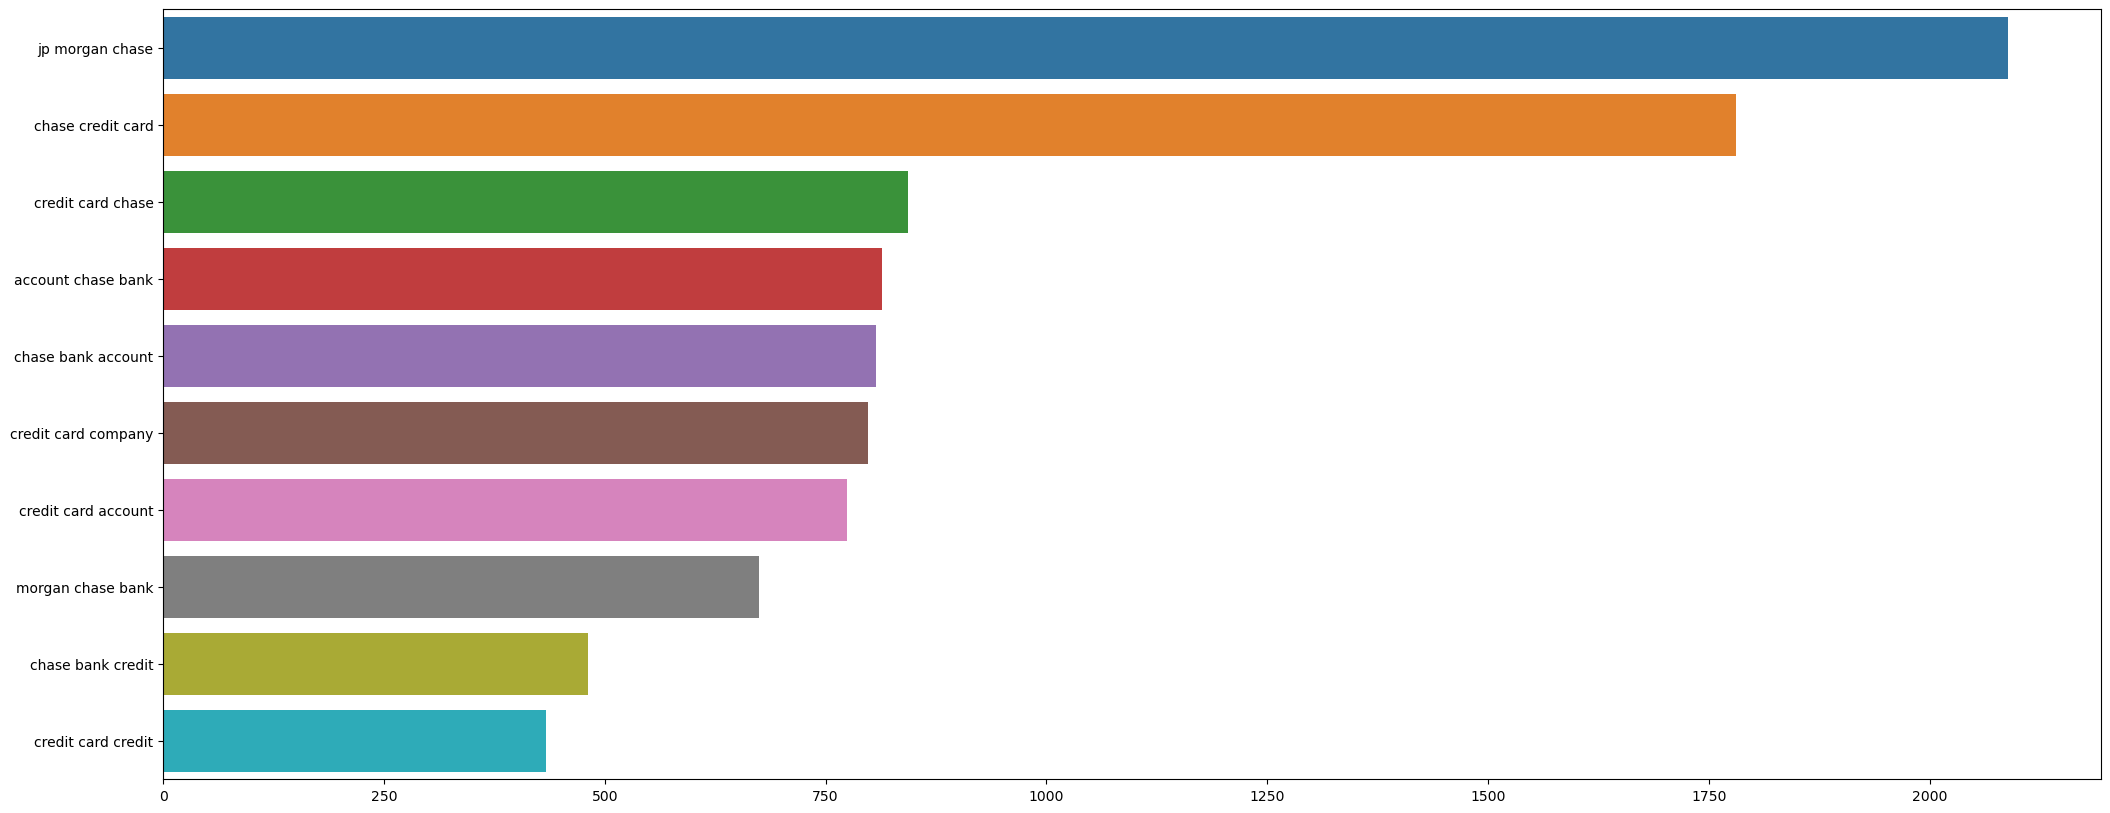

In [32]:
#Print the top 10 words in the trigram frequency
show_ngram(3,10)

In [33]:
#All masked texts has been removed
df_clean.head()

,complaints,complaints_lemma,complaints_pos_removed
1,good morning my name is and i appreciate it i...,good morning my name be and I appreciate it ...,morning name stop bank cardmember services deb...
2,i upgraded my card in and was told by the ag...,I upgrade my card in and be tell by the ag...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card application identity consent servic...
11,on while trying to book a ticket i came acro...,on while try to book a ticket I come acros...,ticket offer ticket rewards card information o...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son check chase account fund chase bank accoun...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [34]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=2,max_df=0.95,stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [35]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

dtm = tfidf.fit_transform(df_clean['complaints_pos_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [36]:
# using gensim for automatic topic numbers
dataset = [d.split() for d in df_clean['complaints_pos_removed']]

dictionary = Dictionary(dataset)
dictionary.filter_extremes(no_below=3,no_above=0.95,keep_n=5000)
corpus = [dictionary.doc2bow(text) for text in dataset]
topic_nums = list(range(5,20,1))

coherence_scores = []


for num in topic_nums:
    nmf = Nmf(corpus=corpus , num_topics=num, id2word=dictionary,normalize=True,random_state=40)
    cm = CoherenceModel(model=nmf, texts=df_clean['complaints_pos_removed'],dictionary=dictionary,coherence='c_v') 
    coherence_scores.append(round(cm.get_coherence(),5))

scores = list(zip(topic_nums,coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]
print(best_num_topics)


/Users/pulkitgangwar/miniconda/envs/data-science/lib/python3.10/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/pulkitgangwar/miniconda/envs/data-science/lib/python3.10/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning:

invalid value encountered in double_scalars



5


In [37]:
# printing the best number of topics
print(best_num_topics)

5


In [38]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [39]:
#Load your nmf_model with the n_components i.e 5
num_topics = best_num_topics 

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40)

In [40]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

8690

In [41]:
#Print the Top15 words for each of the topics

topic_words = {0:[],1: [],2: [],3: [],4: []}


for index,topic in enumerate(nmf_model.components_):
    topic_words[index] = [tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]]
print('TOPIC : WORDS')

for (topic,words) in topic_words.items():
    print(f'{topic} : {words}')

TOPIC : WORDS
0 : ['fraud', 'checks', 'days', 'number', 'business', 'accounts', 'checking', 'deposit', 'branch', 'funds', 'money', 'check', 'chase', 'bank', 'account']
1 : ['bureaus', 'information', 'reporting', 'limit', 'debt', 'chase', 'account', 'accounts', 'score', 'cards', 'inquiries', 'card', 'inquiry', 'report', 'credit']
2 : ['time', 'rate', 'morgan', 'letter', 'house', 'years', 'bank', 'foreclosure', 'payments', 'property', 'modification', 'home', 'chase', 'mortgage', 'loan']
3 : ['service', 'claim', 'phone', 'purchase', 'fee', 'company', 'transaction', 'merchant', 'fraud', 'dispute', 'credit', 'charge', 'charges', 'chase', 'card']
4 : ['day', 'months', 'account', 'days', 'chase', 'time', 'auto', 'date', 'statement', 'fee', 'fees', 'month', 'balance', 'payments', 'payment']


In [43]:
topic_results = nmf_model.transform(dtm)

In [49]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [61]:
df_clean.head()

,complaints,complaints_lemma,complaints_pos_removed,Topic
1,good morning my name is and i appreciate it i...,good morning my name be and I appreciate it ...,morning name stop bank cardmember services deb...,0
2,i upgraded my card in and was told by the ag...,I upgrade my card in and be tell by the ag...,card agent anniversary date agent information ...,3
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card application identity consent servic...,1
11,on while trying to book a ticket i came acro...,on while try to book a ticket I come acros...,ticket offer ticket rewards card information o...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son check chase account fund chase bank accoun...,0


In [51]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values('Topic')

,complaints,complaints_lemma,complaints_pos_removed,Topic
1,good morning my name is and i appreciate it i...,good morning my name be and I appreciate it ...,morning name stop bank cardmember services deb...,0
24,mishandling of this account by chase auto and,mishandle of this account by chase auto and,account chase auto,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice jp morgan chase account debit card tues...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son check chase account fund chase bank accoun...,0
27,i opened an account with chase bank on and use...,I open an account with chase bank on and use a...,account chase bank code bonus terms everything...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card application identity consent servic...,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,credit card data credit report company issue,1
26,i have reached out to several times in attempt...,I have reach out to several time in attempt to...,times attempt inquiry creditor inquiry report ...,1
11,on while trying to book a ticket i came acro...,on while try to book a ticket I come acros...,ticket offer ticket rewards card information o...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [52]:
#Create the dictionary of Topic names and Topics

Topic_names = { 
    0: 'Bank Account services',
    1:'Credit card or prepaid card',
    2: 'Mortgage/Loan',
    3: 'Theft/Dispute Reporting',
    4: 'Others'
  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [54]:
df_clean.head()

,complaints,complaints_lemma,complaints_pos_removed,Topic
1,good morning my name is and i appreciate it i...,good morning my name be and I appreciate it ...,morning name stop bank cardmember services deb...,Bank Account services
2,i upgraded my card in and was told by the ag...,I upgrade my card in and be tell by the ag...,card agent anniversary date agent information ...,Theft/Dispute Reporting
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card application identity consent servic...,Credit card or prepaid card
11,on while trying to book a ticket i came acro...,on while try to book a ticket I come acros...,ticket offer ticket rewards card information o...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son check chase account fund chase bank accoun...,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [55]:
#Create the dictionary again of Topic names and Topics

Topic_names = { 
    'Bank Account services':0,
    'Credit card or prepaid card':1,
     'Mortgage/Loan':2,
     'Theft/Dispute Reporting':3,
     'Others':4
  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [56]:
df_clean.head()

,complaints,complaints_lemma,complaints_pos_removed,Topic
1,good morning my name is and i appreciate it i...,good morning my name be and I appreciate it ...,morning name stop bank cardmember services deb...,0
2,i upgraded my card in and was told by the ag...,I upgrade my card in and be tell by the ag...,card agent anniversary date agent information ...,3
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card application identity consent servic...,1
11,on while trying to book a ticket i came acro...,on while try to book a ticket I come acros...,ticket offer ticket rewards card information o...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son check chase account fund chase bank accoun...,0


In [58]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaints','Topic']]

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [60]:

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_cnt = count_vect.fit_transform(training_data['complaints'])


#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

In [61]:
X_train_tfidf.shape

(21072, 33578)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [70]:
# train test split
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,classification_report

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf,training_data['Topic'],test_size=0.25,random_state=40)


print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (15804, 33578)
Shape of y_train: (15804,)
Shape of X_test: (5268, 33578)
Shape of y_test: (5268,)


In [119]:
# model metadata dictionary
models = pd.DataFrame(columns = ['Models','Best'])
models['Models'] = ['Logistic Regression','Decision Tree Classifier','Naive Bayes']
models.set_index('Models',inplace=True)

In [71]:
# function to plot classification report 
topics=["Bank Account services","Credit card or prepaid card","Mortgage/Loan",
        "Theft/Dispute Reporting", "Others"]
def report(pred, title):
    plt.figure(figsize=[15,10])
    sns.heatmap(pd.DataFrame(classification_report(y_test, pred, target_names = topics, output_dict=True)).iloc[:-1, :].T,
            cmap="Blues", annot=True)
    plt.title(title)
    plt.show()

## Logistic Regression

In [98]:
# hyperparameter tuning for logistic regression
penalty = ['l1','l2','elasticnet']
c_values = [100,10,5,3,2,1,0.1,0.01]


logistic = LogisticRegression(random_state=40)


grid = [
    {'C': c_values,'solver':['newton-cg','sag'],'penalty':['l2']},
    {'C': c_values,'solver':['liblinear'],'penalty':['l1','l2']},
    {'C': c_values,'solver':['saga'],'penalty':penalty}
]

grid_search_logistic = GridSearchCV(estimator=logistic,param_grid=grid,n_jobs=-1,cv=5,scoring='f1_weighted',verbose=True)
grid_result_logistic = grid_search_logistic.fit(X_train,y_train)



Fitting 5 folds for each of 56 candidates, totalling 280 fits


/Users/pulkitgangwar/miniconda/envs/data-science/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pulkitgangwar/miniconda/envs/data-science/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pulkitgangwar/miniconda/envs/data-science/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pulkitgangwar/miniconda/envs/data-science/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pulkitgangwar/miniconda/envs/data-science/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

In [100]:
# printing the best estimator values
print("Best %f using %s" % (grid_result_logistic.best_score_, grid_result_logistic.best_params_))

Best 0.956593 using {'C': 3, 'penalty': 'l1', 'solver': 'saga'}


Best F1 Score: 0.9607105977709026


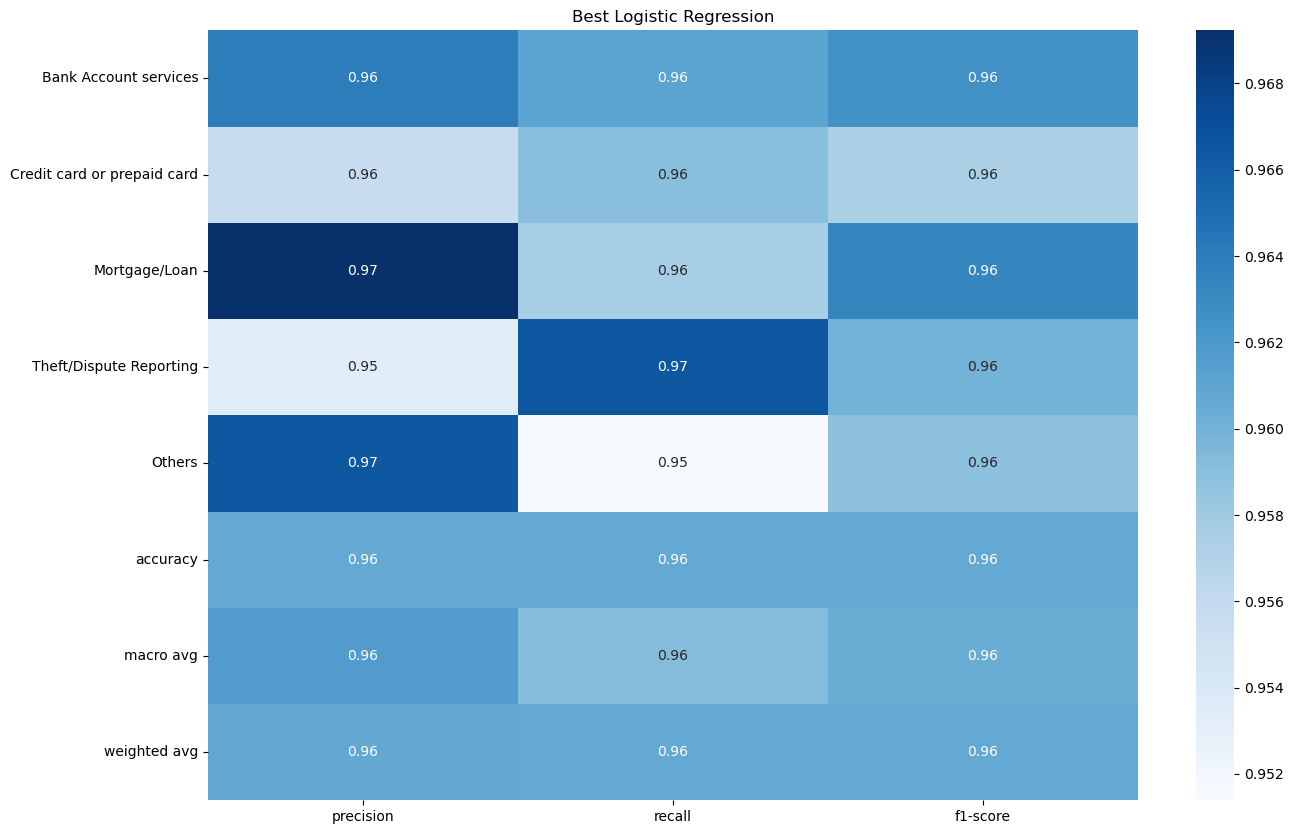

In [120]:
# generating report
logistic_best = grid_result_logistic.best_estimator_
y_pred = logistic_best.predict(X_test)
score = f1_score(y_test, y_pred, average="weighted")
models['Best'][0] = score
print('Best F1 Score: ' + str(score))
report(y_pred,'Best Logistic Regression')

## Decision Trees

In [102]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [103]:
# DecisionTree Estimator
dectree = DecisionTreeClassifier(random_state=40)

In [104]:
# hyperparameter tuning for Decision Tree
max_depth= [10, 25, 50, 100, 500, None]
min_samples_split = np.arange(2, 30, 2)
min_samples_leaf = np.arange(1, 30, 2)
max_features = ['sqrt', 'log2', 'auto', None]
# define grid search
grid = dict(max_features=max_features, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
grid_search_dt = RandomizedSearchCV(estimator=dectree, param_distributions=grid, n_jobs=-1, cv=5, random_state=40, scoring='f1_weighted', verbose=True)
grid_result_dt = grid_search_dt.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/pulkitgangwar/miniconda/envs/data-science/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/pulkitgangwar/miniconda/envs/data-science/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/pulkitgangwar/miniconda/envs/data-science/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/pulkitgangwar/miniconda/envs/data-science/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has be

In [105]:
# summarize results
print("Best: %f using %s" % (grid_result_dt.best_score_, grid_result_dt.best_params_))

Best: 0.802103 using {'min_samples_split': 18, 'min_samples_leaf': 27, 'max_features': None, 'max_depth': 100}


Best F1 Score: 0.8105964141618093


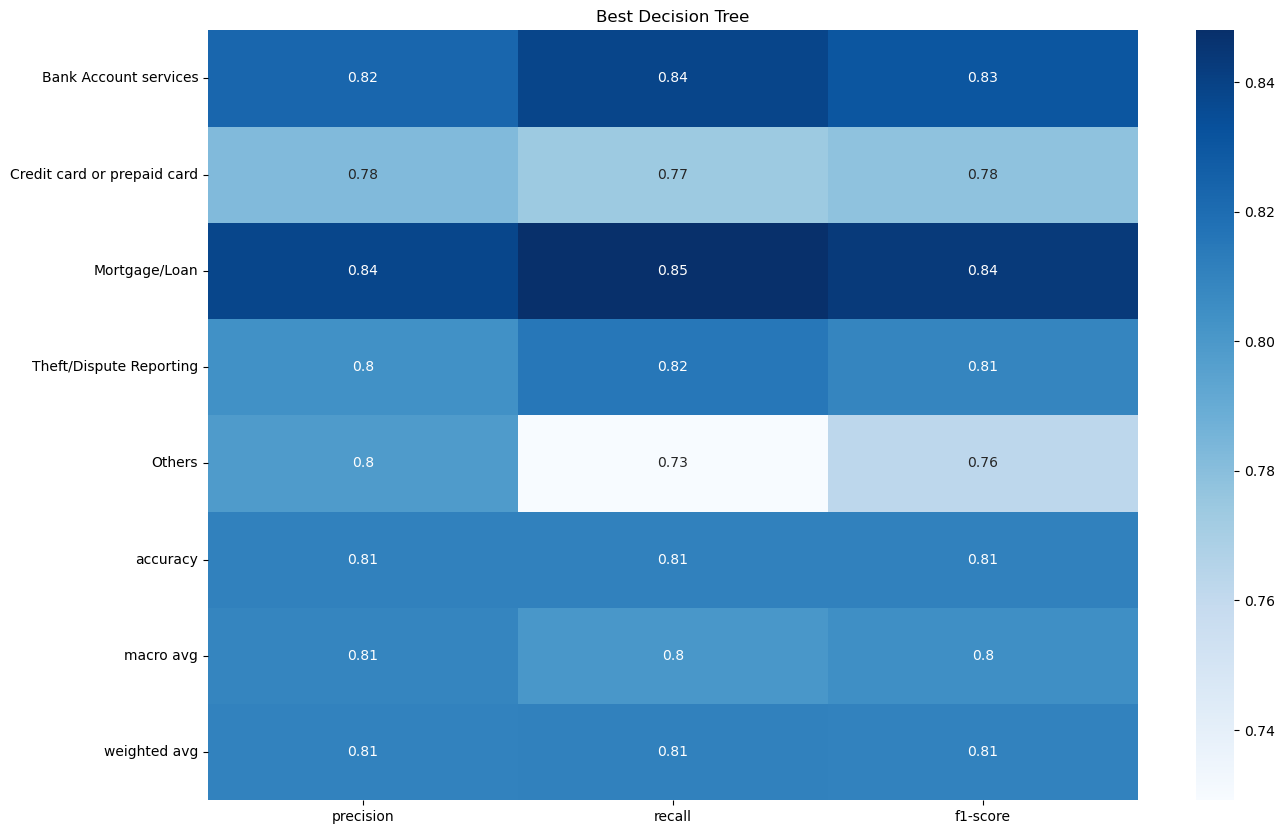

In [121]:
# generating report
dectree_best = grid_result_dt.best_estimator_
y_pred = dectree_best.predict(X_test)
score = f1_score(y_test, y_pred, average="weighted")
models['Best'][1] = score
print('Best F1 Score: ' + str(score))
report(y_pred,'Best Decision Tree')

## Naive Bayes

In [107]:
from sklearn.naive_bayes import MultinomialNB 

In [108]:
nvbayes = MultinomialNB()

In [109]:
# Hyperparameter Tuning for naive bayes

alpha = (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)
fit_prior = [True, False]
# define grid search
grid = dict(alpha=alpha,fit_prior=fit_prior)
grid_search_nv = GridSearchCV(estimator=nvbayes, param_grid=grid, n_jobs=-1, cv=5, scoring='f1_weighted', verbose=True)
grid_result_nv = grid_search_nv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [110]:
# summarize results
print("Best: %f using %s" % (grid_result_nv.best_score_, grid_result_nv.best_params_))

Best: 0.790466 using {'alpha': 0.1, 'fit_prior': False}


Best F1 Score: 0.7876363354519862


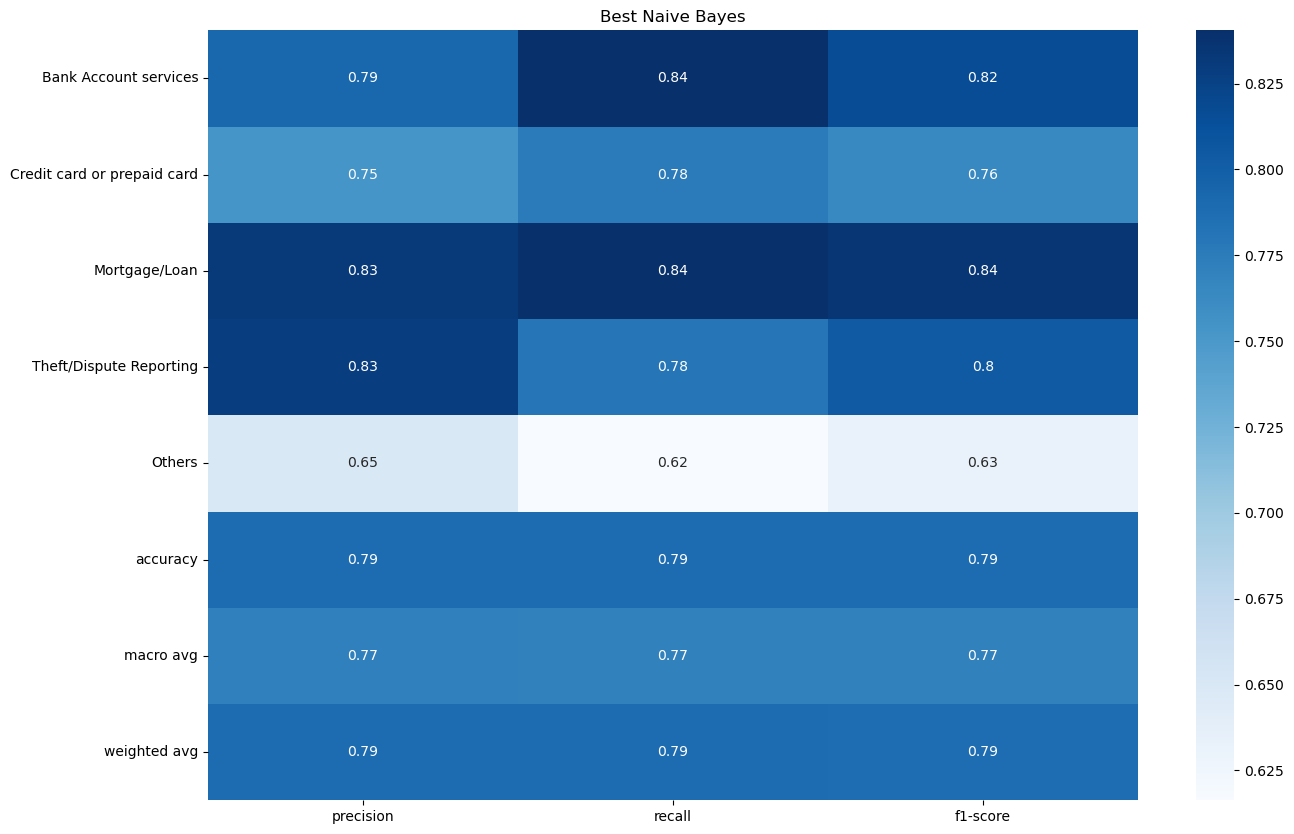

In [122]:
# generating report
nvbayes_best = grid_result_nv.best_estimator_
y_pred = nvbayes_best.predict(X_test)
score = f1_score(y_test, y_pred, average="weighted")
models['Best'][2] = score
print('Best F1 Score: ' + str(score))
report(y_pred,'Best Naive Bayes')

## Model Inference

In [134]:
# Create a dataframe of some sample customer complaints
df_final = pd.DataFrame({'complaints': 
[ "I fell behind in my FHA mortgage on or around of  due to an injury that kept me out of work temporarily. I am planning to return to work shortly but in the interim, I requested a forbearance from my mortgage company, Freedom Mortgage.", 
  "These are not mines I was a Victim of Identity Thief. This is wrong on my credit report, I want these removed Please. ",
  "I changed phone companies and they wouldnt port my previous number so it was changed Vio Bank a division owned by Midfirst bank will not change my phone number on my account.",
  "Accounts were closed, without warning or reasons to which were addressed & managed by bank branch manager, who made it known, that everything was good and verified by account holder, and request had been resolved.",
  "I put my loan in forbearance offered under cares act during the pandemic and the bank has jacked up the amount to high than it was before. I need an explanation because I understood that under the cares act there should not be any interest charges for the loan during the forbearance period.",
]})
df_final

,complaints
0,I fell behind in my FHA mortgage on or around ...
1,These are not mines I was a Victim of Identity...
2,I changed phone companies and they wouldnt por...
3,"Accounts were closed, without warning or reaso..."
4,I put my loan in forbearance offered under car...


In [135]:
target_names = ["Bank Account services","Credit card or prepaid card","Mortgage/Loan","Theft/Dispute Reporting","Others"]

def predict_topic(text):
    X_final_counts =  count_vect.transform(text)
    X_final_tfidf = tfidf_transformer.transform(X_final_counts)
    predicted = logistic_best.predict(X_final_tfidf)

    return target_names[predicted[0]]

In [136]:
df_final['predicted topic'] = df_final['complaints'].apply(lambda x: predict_topic([x]))
df_final

,complaints,predicted topic
0,I fell behind in my FHA mortgage on or around ...,Mortgage/Loan
1,These are not mines I was a Victim of Identity...,Credit card or prepaid card
2,I changed phone companies and they wouldnt por...,Bank Account services
3,"Accounts were closed, without warning or reaso...",Bank Account services
4,I put my loan in forbearance offered under car...,Mortgage/Loan


In [123]:
models

,Best
Models,
Logistic Regression,0.960711
Decision Tree Classifier,0.810596
Naive Bayes,0.787636


```
Best the model is logistic regression 
```